# V1 Model 

V1 model 

# Introduction to Apache Cerebrum 

## Motivation

- Large public databases provide extensive and detailed maps of the brain (e.g. Brain Atlas) . 
- Using such atlases for the construction of computational models remains a challenge. 
- Diverse databases are required for construction of detailed models.
   - Spatial transcriptomics data allows for regional and layer-wise distributions of the different cell types. 
   - Synaptic physiology databases provide connection probabilities between the sets of neuron classes. 
- Data from diverse sources incorporated to construct detailed models 

## Cerebrum Goals 

- Flexible and extendable software that allows queries over different databases and brain atlases.
- Applies transformations such as maps and filters on the resultant data.
- Incorporate results within the computational models described using SONATA format


## Workflow Structure

Workflow to construct in Cerebrum follows the following steps: 

1. Extract data from experimental and brain atlas datasets via querying the  relevant databases. 
2. Map acquired data to regions of interest. 
3. Fill-in any missing details via an optional user-defined custom modifications. 
4. Realize the final network of neurons in SONATA format from the model recipe.

<div>
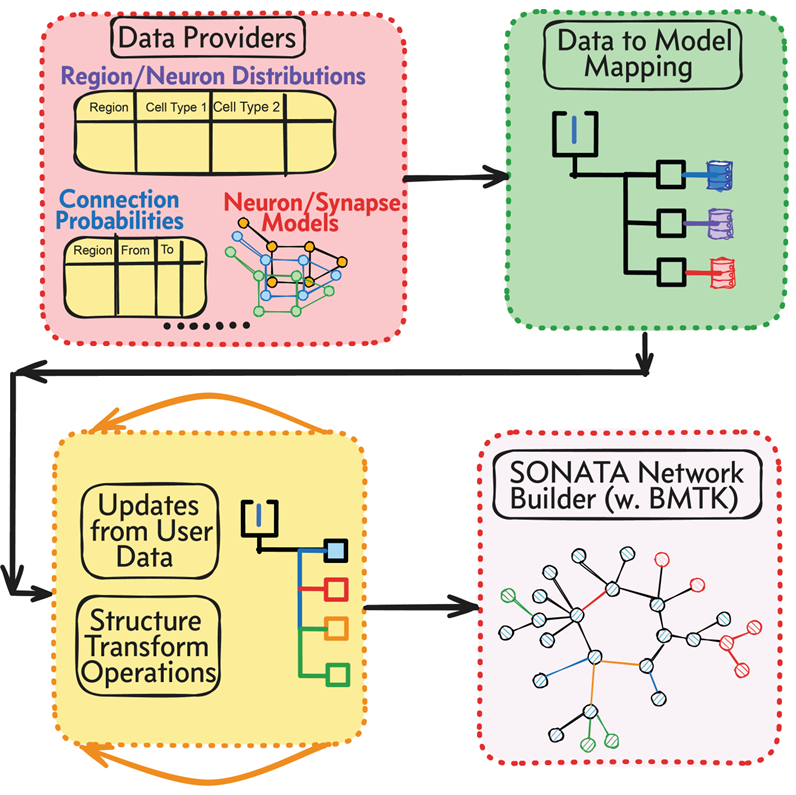
</div>

In [1]:
%load_ext autoreload
%autoreload 2 

In [1]:
import logging
from typing import NamedTuple
import pydantic
import nest
#
from pathlib import Path
#
from nest.lib.hl_api_sonata import SonataNetwork
from nest.lib.hl_api_nodes import Create as NestCreate
from nest.lib.hl_api_connections import Connect as NestConnect
from nest.lib.hl_api_types import NodeCollection
#
import mousev1.model as v1model
import mousev1.operations as v1ops
from airavata_cerebrum.model.setup import RecipeSetup
from airavata_cerebrum.model.recipe import ModelRecipe
from airavata_cerebrum.model.structure import Network
from airavata_cerebrum.view.tree import DataSourceRecipeView, Data2ModelRecipeView, NetworkStructureView



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:32:09

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



# Setup the Model Recipe and the Recipe Templates

Model recipe is defined by a recipe file named recipe.json and template file name recipe_template.json. 
The files are placed in the recipe directory, canonically under the base directory of the model.

## recipe.json

recipe.json contains two sections: (1) data2model_map and (2) source_data. 
data2model_map maps between how the different parts of the model map to the source data. 
The source_data describes how the source databases are connected and different operations such as filters are applied to the data available from the specific database.

In [3]:
class RcpSettings(pydantic.BaseModel):
    name: str = "v1"
    base_dir: Path = Path("./")
    recipe_dir: Path = Path("./v1/recipe/")
    recipe_files: dict[str, list[str | Path]] = {
       "recipe": [
            "recipe.json",
            "recipe_data.json",
            "recipe_dm_l1.json",
            "recipe_dm_l23.json",
            "recipe_dm_l4.json",
            "recipe_dm_l5.json",
            "recipe_dm_l6.json",
        ],
        "templates": [
            "recipe_template.json"
        ]
    }
    custom_mod: list[str | Path] = [
        Path("./v1/recipe/custom_mod.json"),
        Path("./v1/recipe/custom_mod_l1.json"),
        Path("./v1/recipe/custom_mod_l23.json"),
        Path("./v1/recipe/custom_mod_l4.json"),
        Path("./v1/recipe/custom_mod_l5.json"),
        Path("./v1/recipe/custom_mod_l6.json"),
        Path("./v1/recipe/custom_mod_ext.json"),
        Path("./v1/recipe/custom_mod_ext_lgn.json"),
        Path("./v1/recipe/custom_mod_ext_bkg.json"),
    ]
    ctdb_models_dir: Path = Path("./v1/components/point_neuron_models/")
    nest_models_dir: Path = Path("./v1/components/cell_models/")
    save_flag: bool = True

def recipe_setup(rcp_set: RcpSettings):
    return RecipeSetup(
        name=rcp_set.name,
        base_dir=rcp_set.base_dir,
        recipe_files=rcp_set.recipe_files,
        recipe_dir=rcp_set.recipe_dir,
        create_model_dir=True,
    )

rcp_set = RcpSettings()
md_recipe_setup = recipe_setup(rcp_set)
custom_mod_struct = Network.from_file_list(rcp_set.custom_mod) 


# Visualize Structure for Source Data 

Data provider module includes
  - Methods for defining the querying from the database and filter the data based on specific criteria. 
  - Utilities to visualize the data provider configurations in easy-to-understand explorer view inside Jupyter notebook with the relevant parameters displayed in the side panel.

Construction of Layer 4 of Mouse V1 is shown below with three different data providers: 
  - Allen Cell Types database,
  - Allen Brain Cell Atlas and
  - AI Synaptic Physiology Database. 

Using the templates we can view the links to the source data and the model with Jupter notebook widgets. 

In [4]:
import IPython.display

IPython.display.JSON(md_recipe_setup.get_section('source_data'))

<IPython.core.display.JSON object>

In [5]:
sd_tree = DataSourceRecipeView(md_recipe_setup, left_width="55%")
sd_tree.build()
sd_tree.layout

TwoByTwoLayout(children=(Tree(data={'id': '-source_data', 'text': 'Data Sources', 'state': {'selected': True, …

# Data2Model Map

Definitions for data2model includes two parts:

1. *Locations:* Cell types database and the MERFISH atlas data map to neuron models and the distribution of neuron types, respectively
2. *Connections:* AI synaptic physiology data is mapped to the connection probabilities between the pairs of neuron classes.     

## View for Locations

Locations are defined hiearchially with each section defining the data links. For V1 layer 4, we map five different neuron types to the specific models and the region fractions.

Using the templates we can view the links to the neurons and the source data with Jupter notebook widgets. Running the next cell should produce a visualization in the image below:

## View for Connections

Connections are defined as section for each pair to neuron sets, with each section defining the data links. For V1 layer 4, we map eight different neuron pairs to the AI Syn. Phys. Data outputs.

Using the templates we can view the links to the neuron pairs and the source data with Jupter notebook widgets. Running the next cell should produce a visualization in the image below:




In [ ]:
import IPython.display

IPython.display.JSON(md_recipe_setup.get_section('data2model_map'))

In [6]:
dm_tree = Data2ModelRecipeView(md_recipe_setup, width="55%")
dm_tree.build()
dm_tree.layout

TwoByTwoLayout(children=(Tree(data={'id': '-data2model_map', 'text': 'Data->Model', 'state': {'selected': True…

## Custom Modification

Custom modifications if defined byt the "custom_mod.json". It includes:
- Users can provide details required for network construction that are either not available in the linked databases or over-ride specific information.
- Utilities to visualize these modifications in Jupyter Notebook.

For the Layer 4 of Mouse V1, custom modifications include 
1. Dimensions of each region in the model.
2. Connection Parameters not available with the AI Syn. Phys. database.
3. Details of the networks that are external to V1  LGN and the  background networks. 

Using the templates we can view the user custom modifications with Jupter notebook widgets. 

**Due to Size Restrictions, this doesn't work in ipython for now**

In [7]:
import IPython.display

IPython.display.JSON(custom_mod_struct.model_dump())

<IPython.core.display.JSON object>

**Due to Size Restrictions, this doesn't work in ipython for now**

In [ ]:
cmod_view = cbm_tree.NetworkStructureView(custom_mod_struct, left_width="55%")
cmod_view.build()
cmod_view.layout

## Mappers for *Model Recipe* to *SONATA Network*
To realize model recipe 
1. *Region Mapper* : Maps the location to a region in the network
2. *Neuron Mapper* : Map the neuron details in the location to a neuron class within the region
3. *Connection Mapper*: Map the connection data to a connection object

In addition a *Network Builder* class is also defined that translates the model description to SONATA network. 

In [8]:
model_recipe = ModelRecipe(
    recipe_setup=md_recipe_setup,
    region_mapper=v1model.V1RegionMapper,
    neuron_mapper=v1model.V1NeuronMapper,
    connection_mapper=v1model.V1ConnectionMapper,
    network_builder=v1model.V1BMTKNetworkBuilder,
    mod_structure=custom_mod_struct,
    save_flag=rcp_set.save_flag,
)
# logging.basicConfig(level=logging.INFO)

# Data Acquistition

Data acquisition consists of the following two steps:

## Run Data Download Workflow

After the model description is defined and updated with custom user modifications, the download workflow proceeds as follows:
1. Download the data
2. Apply the filters and transormations
3. Map data to the model components
4. Apply user modifications
5. Build the SONATA file

## Run Download Post Operations

After data is dowloaded, the data obtained from different databases need to processed separately:

1.  In case of the Allen Cell Type database, the download step can be restricted only to obtain the metadata related to cell types. After the meta data is downloaded, we need to acquire the models of interest (3 LIF Models). We use the GLIF API from allensdk to download these 3LIF model with a explained variance threshold.
2.  For data from Allen Brain Cell Atlas, we filter the data specific to only the VISp Layer 4
3.  For AI Syn Phys. data, we select only the neuron pairs of our interest.

We accomplish the above two steps by running acquire_source_data() function.

In [9]:
db_source_data = model_recipe.acquire_source_data()

  0%|          | 0/2333 [00:00<?, ?it/s]

/storage/hive/project/cse-aluru/schockalingam6/spack/opt/spack/linux-rhel9-cascadelake/gcc-12.3.0/miniforge3-24.3.0-0-aqhmckaascr5r262m24t2yk3fjx52dqs/envs/cerebrum/lib/python3.10/site-packages/aisynphys/connectivity.py:323: RuntimeWarning:Mean of empty slice.
/storage/hive/project/cse-aluru/schockalingam6/spack/opt/spack/linux-rhel9-cascadelake/gcc-12.3.0/miniforge3-24.3.0-0-aqhmckaascr5r262m24t2yk3fjx52dqs/envs/cerebrum/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:invalid value encountered in double_scalars
/storage/hive/project/cse-aluru/schockalingam6/spack/opt/spack/linux-rhel9-cascadelake/gcc-12.3.0/miniforge3-24.3.0-0-aqhmckaascr5r262m24t2yk3fjx52dqs/envs/cerebrum/lib/python3.10/site-packages/aisynphys/connectivity.py:329: RuntimeWarning:invalid value encountered in long_scalars
/storage/hive/project/cse-aluru/schockalingam6/spack/opt/spack/linux-rhel9-cascadelake/gcc-12.3.0/miniforge3-24.3.0-0-aqhmckaascr5r262m24t2yk3fjx52dqs/envs/cerebrum/lib/python3

# Explore downloaded data

Output data are stored in the description directory in json format (db_connect_output.json), which can be examine with json library. Here are examples of Region and Neuron fractions of the Allen Brain Atlas, and connectivity matrix downloaded from AI Syn. Phys. dataset

In [10]:
import json
#
with open("./v1l4/recipe/db_connect_output.json") as dbf:
    db_out_data = json.load(dbf)


In [11]:
import airavata_cerebrum.dataset.abc_mouse as abcm
abcm.DFBuilder.build(db_out_data['airavata_cerebrum.dataset.abc_mouse'])

shape: (6, 17)
┌────────┬───────┬─────────┬─────────────┬───┬─────────────┬─────────────┬────────────┬────────────┐
│ Region ┆ Layer ┆ nregion ┆ inhibitory  ┆ … ┆ ET fraction ┆ CT fraction ┆ NP         ┆ IT         │
│ ---    ┆ ---   ┆ ---     ┆ fraction    ┆   ┆ ---         ┆ ---         ┆ fraction   ┆ fraction   │
│ str    ┆ str   ┆ i64     ┆ ---         ┆   ┆ f64         ┆ f64         ┆ ---        ┆ ---        │
│        ┆       ┆         ┆ f64         ┆   ┆             ┆             ┆ f64        ┆ f64        │
╞════════╪═══════╪═════════╪═════════════╪═══╪═════════════╪═════════════╪════════════╪════════════╡
│ VISp   ┆ 1     ┆ 61884   ┆ 0.405155    ┆ … ┆ 0.0         ┆ 0.0         ┆ 0.0        ┆ 0.989601   │
│ VISp   ┆ 2/3   ┆ 61884   ┆ 0.078755    ┆ … ┆ 0.0         ┆ 0.0         ┆ 0.0        ┆ 1.0        │
│ VISp   ┆ 4     ┆ 61884   ┆ 0.111916    ┆ … ┆ 0.029334    ┆ 0.000212    ┆ 0.007413   ┆ 0.962618   │
│ VISp   ┆ 5     ┆ 61884   ┆ 0.165428    ┆ … ┆ 0.323039    ┆ 0.043953    ┆ 0.104137   ┆ 0.521258   │
│ VISp   ┆ 6a    ┆ 61884   ┆ 0.062779    ┆ … ┆ 0.000611    ┆ 0.75932     ┆ 0.005378   ┆ 0.215988   │
│ VISp   ┆ 6b    ┆ 61884   ┆ 0.05291     ┆ … ┆ 0.0         ┆ 0.725559    ┆ 0.0        ┆ 0.046788   │
└────────┴───────┴─────────┴─────────────┴───┴─────────────┴─────────────┴────────────┴────────────┘

In [12]:
import airavata_cerebrum.dataset.ai_synphys as aisp
aisp.DFBuilder.build(db_out_data['airavata_cerebrum.dataset.ai_synphys'])

shape: (16, 3)
┌─────────────┬──────────────┬──────────────┐
│ pre_synapse ┆ post_synapse ┆ connect_prob │
│ ---         ┆ ---          ┆ ---          │
│ str         ┆ str          ┆ f64          │
╞═════════════╪══════════════╪══════════════╡
│ L4-Pyr      ┆ L4-Pyr       ┆ 0.125985     │
│ L4-Pyr      ┆ L4-Pvalb     ┆ 0.198113     │
│ L4-Pyr      ┆ L4-Sst       ┆ 0.045855     │
│ L4-Pyr      ┆ L4-Vip       ┆ 0.049624     │
│ L4-Pvalb    ┆ L4-Pyr       ┆ 0.356604     │
│ …           ┆ …            ┆ …            │
│ L4-Sst      ┆ L4-Vip       ┆ 0.306504     │
│ L4-Vip      ┆ L4-Pyr       ┆ 0.0          │
│ L4-Vip      ┆ L4-Pvalb     ┆ 0.025412     │
│ L4-Vip      ┆ L4-Sst       ┆ 0.18856      │
│ L4-Vip      ┆ L4-Vip       ┆ 0.03499      │
└─────────────┴──────────────┴──────────────┘

## Mapping Source data

In this step, the data downloaded is mapped to the locations and the connection pairs as mentioned in "Data2Model Map" section above.


In [13]:
logging.basicConfig(level=logging.INFO)
#
msrc = model_recipe.map_source_data()

INFO:airavata_cerebrum.workflow:Processing db connection for neuron [property_map]
INFO:airavata_cerebrum.workflow:Start op workflow for db [airavata_cerebrum.dataset.abc_mouse]
INFO:airavata_cerebrum.workflow:Running XFormer : [Select Region]
INFO:airavata_cerebrum.workflow:Complete XForm : [Select Region]
INFO:airavata_cerebrum.workflow:Complete op workflow for db [airavata_cerebrum.dataset.abc_mouse]
INFO:airavata_cerebrum.workflow:Completed db connection for neuron [property_map]
INFO:airavata_cerebrum.workflow:Processing db connection for neuron [('1', 'Htr3a')]
INFO:airavata_cerebrum.workflow:Start op workflow for db [airavata_cerebrum.dataset.abm_celltypes]
INFO:airavata_cerebrum.workflow:Running XFormer : [Select Line]
INFO:airavata_cerebrum.operations.dict_filter:IterAttrFilter Args : (key:ct, filters:[('structure__layer', <built-in function eq>, '1'), ('line_name', <built-in function contains>, 'Htr3a'), ('cell_reporter_status', <built-in function eq>, 'positive')])
INFO:aira

# Apply User Modification

As mentioned in the "User Modification" section above user updates for the model are loaded from "./v1l4/description/custom_mod.json".

For V1L4, the user modification include dimension, additional connection properties, and properties of external netowrks

In [14]:
IPython.display.JSON(custom_mod_struct.model_dump())

<IPython.core.display.JSON object>

In [15]:
msrc = model_recipe.build_net_struct()
msrc = model_recipe.apply_mod(80000)

In [16]:
import mousev1.model as v1model
bmtk_net_builder = v1model.V1BMTKNetworkBuilder(model_recipe.network_struct)
bmtk_net = bmtk_net_builder.build()

('1', 'Htr3a') 482654108 1857 4051
('1', 'Htr3a') 475585413 1857 4051
('1', 'Htr3a') 482649712 1857 4051
('2/3', 'Cux2') 513593674 2569 4075
('2/3', 'Cux2') 513510227 2569 4075
('2/3', 'Cux2') 486262299 2569 4075
('2/3', 'Cux2') 490376252 2569 4075
('2/3', 'Cux2') 486753754 2569 4075
('2/3', 'Cux2') 489751692 2569 4075
('2/3', 'Cux2') 513531471 2569 4075
('2/3', 'Cux2') 505512874 2569 4075
('2/3', 'Cux2') 517319635 2569 4075
('2/3', 'Cux2') 484509440 2569 4075
('2/3', 'Vip') 524689239 69 2720
('2/3', 'Vip') 524693113 69 2720
('2/3', 'Vip') 501736631 69 2720
('2/3', 'Vip') 560814288 69 2720
('2/3', 'Vip') 522418855 69 2720
('2/3', 'Vip') 524876305 69 2720
('2/3', 'Vip') 523478869 69 2720
('2/3', 'Vip') 575920560 69 2720
('2/3', 'Vip') 514767977 69 2720
('2/3', 'Vip') 562539062 69 2720
('2/3', 'Pvalb') 469614747 60 8163
('2/3', 'Pvalb') 485245025 60 8163
('2/3', 'Pvalb') 488501071 60 8163
('2/3', 'Pvalb') 574992320 60 8163
('2/3', 'Pvalb') 485184849 60 8163
('2/3', 'Pvalb') 477490421 60 

# Save SONATA

Save SONATA with BMTK

In [ ]:
bmtk_net_builder.net.save(str(md_recipe_setup.network_dir))
bmtk_net_builder.bkg_net.save(str(md_recipe_setup.network_dir))

# Run the SONATA Network in NEST

1. Convert downloaded models to NEST confirmed models
2. Load SONATA network in NEST
3. Run Simulation

In [ ]:
# Converting to 
import mousev1.operations as mousev1ops
import nest
import matplotlib.pyplot as plt

mousev1ops.convert_ctdb_models_to_nest(
    "./v1/components/point_neuron_models/",
    "./v1/components/cell_models/"
)


In [ ]:

class NestSonata(NamedTuple):
    net : SonataNetwork | None = None
    spike_rec: NodeCollection | None = None
    multi_meter: NodeCollection | None = None

def load_nest_sonata(
    nest_config_file: str = "./v1/config_nest.json",
):
    # Instantiate SonataNetwork
    sonata_net = SonataNetwork(nest_config_file)

    # Create and connect nodes
    node_collections = sonata_net.BuildNetwork()
    print("Node Collections", node_collections.keys())

    # Connect spike recorder to a population
    spike_rec = NestCreate("spike_recorder")
    NestConnect(node_collections["v1"], spike_rec)

    # Attach Multimeter
    multi_meter = NestCreate(
        "multimeter",
        params={
            # "interval": 0.05,
            "record_from": [
                "V_m",
                "I",
                "I_syn",
                "threshold",
                "threshold_spike",
                "threshold_voltage",
                "ASCurrents_sum",
            ],
        },
    )
    NestConnect(multi_meter, node_collections["v1"])

    # Simulate the network
    # sonata_net.Simulate()
    return NestSonata(sonata_net, spike_rec, multi_meter)

nest_net = load_nest_sonata()

In [ ]:
nest_net.net.Simulate()

In [ ]:
dmm = nest_net.multi_meter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
#
plt.figure(1)
plt.plot(ts, Vms)

In [ ]:
spike_data = nest_net.spike_rec.events
spike_senders = spike_data["senders"]
ts = spike_data["times"]
plt.figure(2)
plt.plot(ts, spike_senders, ".")
plt.show()